In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# import subprocess
# import sys
# subprocess.check_call([sys.executable, "-m", "pip", "install", "-e", "..", "--force-reinstall", "--no-deps"])

In [3]:
from resilient_efleets.src.data.loader import load_all_network_data
from resilient_efleets.src.fleet.schedule import load_bus_schedules
from resilient_efleets.src.simulation.state import SimulationState
from resilient_efleets.src.simulation.engine import SimulationEngine

from resilient_efleets.src.visualization.folium_map import create_network_map
from resilient_efleets.src.visualization.animation import create_bus_animation
from resilient_efleets.src.visualization.dashboard import create_dashboard

In [4]:
print("Loading network data...")
network_data = load_all_network_data()

Loading network data...
Loading network data...
Loaded:
  - 426 unique stops
  - 26 routes
  - 21 charging stations
  - 3 depots


In [5]:
print("Assigning bus schedules...")
buses = load_bus_schedules(
        routes=network_data["routes"],
        depots=network_data["depots"]
    )

Assigning bus schedules...
Created 60 buses with scheduled trips.


In [6]:
state = SimulationState(
        routes=network_data["routes"],
        stops=network_data["stops"],
        charging_stations=network_data["charging_stations"],
        depots=network_data["depots"],
        buses=buses
    )

engine = SimulationEngine(state)

from resilient_efleets.src.config.settings import HybridSimulationSettings

HybridSimulationSettings.SIMULATION_MODE = 'hybrid_adaptive'
HybridSimulationSettings.BATCH_THRESHOLD_SECONDS = 60
HybridSimulationSettings.FINE_STEP_SECONDS = 2*HybridSimulationSettings.BATCH_THRESHOLD_SECONDS
HybridSimulationSettings.COARSE_STEP_SECONDS = 300
HybridSimulationSettings.GAP_THRESHOLD_SECONDS = 300

print("Current Hybrid Simulation Configuration:")
print("="*60)
print(f"SIMULATION_MODE: {HybridSimulationSettings.SIMULATION_MODE}")
print(f"BATCH_THRESHOLD_SECONDS: {HybridSimulationSettings.BATCH_THRESHOLD_SECONDS}s")
print(f"FINE_STEP_SECONDS: {HybridSimulationSettings.FINE_STEP_SECONDS}s")
print(f"COARSE_STEP_SECONDS: {HybridSimulationSettings.COARSE_STEP_SECONDS}s")
print(f"GAP_THRESHOLD_SECONDS: {HybridSimulationSettings.GAP_THRESHOLD_SECONDS}s")
print(f"FIXED_STEP_SECONDS (legacy): {HybridSimulationSettings.FIXED_STEP_SECONDS}s")
print("="*60)

print("\nTo change settings, edit:")
print("  resilient_efleets/src/config/settings.py")
print("\nOr override in code:")
print("  engine.run(mode='hybrid_adaptive', step_seconds=300)")
print("  engine.run(mode='fixed_interval', step_seconds=60)")

Current Hybrid Simulation Configuration:
SIMULATION_MODE: hybrid_adaptive
BATCH_THRESHOLD_SECONDS: 60s
FINE_STEP_SECONDS: 120s
COARSE_STEP_SECONDS: 300s
GAP_THRESHOLD_SECONDS: 300s
FIXED_STEP_SECONDS (legacy): 60s

To change settings, edit:
  resilient_efleets/src/config/settings.py

Or override in code:
  engine.run(mode='hybrid_adaptive', step_seconds=300)
  engine.run(mode='fixed_interval', step_seconds=60)


## Configure Flood Hazard Disruptions (NEW!)

You can now use real flood hazard maps instead of random disruptions.

In [ ]:
# Import flood hazard configuration
from resilient_efleets.src.hazards.flood import FloodHazardConfig

# Configure flood-based disruptions
# Note: Flood map raster values are assumed to be in centimeters (cm)
flood_config = FloodHazardConfig(
    # Select flood map (available: 10, 25, 50, 100, 200, 500 year return periods)
    flood_map_file='Kerala_Flood_100_Yrs_Historical.tif',
    
    # Flood depth threshold in METERS (e.g., 0.5 m)
    flood_depth_threshold_m=0.5,
    
    # Simple hydrology dynamics (rates in cm/hr)
    precipitation_cm_per_hr=0.0,   # add rainfall-driven rise (cm/hour)
    recession_cm_per_hr=0.0,       # drainage recession rate (cm/hour)
    
    # Which components can be disrupted
    disrupt_routes=True,              # Routes with flooded stops
    disrupt_stops=True,               # Individual stops
    disrupt_charging_stations=True,   # Charging infrastructure
    disrupt_depots=False,             # Depots (usually disabled)
    disrupt_buses=False,              # Buses at flooded locations
    
    # Disruption duration
    flood_duration_minutes=120,  # 2 hours
    
    # Enable/disable flood hazards
    enabled=True  # Set to False to disable flood disruptions
)

print("Flood Hazard Configuration:")
print(f"  Map: {flood_config.flood_map_file}")
print(f"  Threshold: {flood_config.flood_depth_threshold_m} m")
print(f"  Precipitation: {flood_config.precipitation_cm_per_hr} cm/hr")
print(f"  Recession: {flood_config.recession_cm_per_hr} cm/hr")
print(f"  Duration: {flood_config.flood_duration_minutes} min")
print(f"  Enabled: {flood_config.enabled}")

Flood Hazard Configuration:
  Map: Kerala_Flood_100_Yrs_Historical.tif
  Threshold: 0.5m
  Duration: 120 min
  Enabled: True


## Create Simulation Engine with Flood Configuration

Now pass the flood_config to the SimulationEngine. You can also disable random disruptions.

In [9]:
# Create simulation engine WITH flood configuration
engine = SimulationEngine(
    state,
    flood_config=flood_config,          # Pass flood configuration
    use_random_disruptions=False         # Disable random disruptions (optional)
)

print("✓ Simulation engine created with flood-based disruptions")
print("  - Flood hazards: ENABLED" if flood_config.enabled else "  - Flood hazards: DISABLED")
print("  - Random disruptions: DISABLED" if not True else "  - Random disruptions: ENABLED")

✓ Loaded flood hazard map: Kerala_Flood_100_Yrs_Historical.tif
  - Shape: (5507, 3161)
  - CRS: EPSG:4326
  - Depth threshold: 0.5m
  - Max flood depth: 12290.00m
✓ Simulation engine created with flood-based disruptions
  - Flood hazards: ENABLED
  - Random disruptions: ENABLED


In [10]:
import time

# Run a 15-hour simulation with 300-second steps
engine.run(duration_hours=15, step_seconds=300, mode='fixed_interval')

#hybrid
# start_time = time.time()
# engine.run(
#     duration_hours=15,

#     mode='hybrid_adaptive'
# )
# hybrid_duration = time.time() - start_time


print("\nYou can now open simulation_log.csv to analyze results!")


SIMULATION MODE: FIXED INTERVAL (300s steps)
SIMULATION START: 2025-12-26 05:55
Duration: 15.0 hours


--- Step 1 | Time: 05:55:00 ---
  🌊 FLOOD: Route 2A Blue — 3 stops flooded
  🌊 FLOOD: Route 8A Air Rail — 7 stops flooded
  🌊 FLOOD: Route 13C Cyan — 6 stops flooded
  🌊 FLOOD: Route 13A Cyan — 6 stops flooded
  🌊 FLOOD: Route 12C Olive — 6 stops flooded
  🌊 FLOOD: Route 10A Indigo — 4 stops flooded
  🌊 FLOOD: Route 5C Violet — 1 stops flooded
  🌊 FLOOD: Route 1C Red — 2 stops flooded
  🌊 FLOOD: Route 8C Air Rail — 6 stops flooded
  🌊 FLOOD: Route 6C Brown — 3 stops flooded
  🌊 FLOOD: Route 7C Green — 2 stops flooded
  🌊 FLOOD: Route 12A Olive — 7 stops flooded
  🌊 FLOOD: Route 9A Orange — 6 stops flooded
  🌊 FLOOD: Route 10C Indigo — 4 stops flooded
  🌊 FLOOD: Route 11C Gold — 6 stops flooded
  🌊 FLOOD: Route 3C Magenta — 1 stops flooded
  🌊 FLOOD: Route 9C Orange — 5 stops flooded
  🌊 FLOOD: Route 6A Brown — 2 stops flooded
  🌊 FLOOD: Route 1A Red — 3 stops flooded
  🌊 FLOOD: Route

## Analyze simulation_log.csv
Quick helpers to inspect the simulation output, event mix, and a sample SoC trace.

In [7]:
# Export network to shapefiles (routes, stops, charging stations, depots)
from resilient_efleets.src.visualization.shapefile_export import export_network_shapefiles

filepaths = export_network_shapefiles(
    routes=network_data["routes"],
    stops=network_data["stops"],
    charging_stations=network_data["charging_stations"],
    depots=network_data["depots"]
)

print("\nShapefile Summary:")
for layer, filepath in filepaths.items():
    print(f"  {layer}: {filepath}")



Exporting bus network to shapefiles in C:\Users\srijithbalakrishnan\OneDrive - Delft University of Technology\Research\My research\Natpac_ebus_fleet\resilient_efleets\output
✓ Exported 26 routes to C:\Users\srijithbalakrishnan\OneDrive - Delft University of Technology\Research\My research\Natpac_ebus_fleet\resilient_efleets\output\routes.shp
✓ Exported 426 stops to C:\Users\srijithbalakrishnan\OneDrive - Delft University of Technology\Research\My research\Natpac_ebus_fleet\resilient_efleets\output\stops.shp
✓ Exported 21 charging stations to C:\Users\srijithbalakrishnan\OneDrive - Delft University of Technology\Research\My research\Natpac_ebus_fleet\resilient_efleets\output\charging_stations.shp
✓ Exported 3 depots to C:\Users\srijithbalakrishnan\OneDrive - Delft University of Technology\Research\My research\Natpac_ebus_fleet\resilient_efleets\output\depots.shp
✓ Network export complete!

Shapefile Summary:
  routes: C:\Users\srijithbalakrishnan\OneDrive - Delft University of Technolo

C:\Users\srijithbalakrishnan\OneDrive - Delft University of Technology\Research\My research\Natpac_ebus_fleet\resilient_efleets\src\visualization\shapefile_export.py:148: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  gdf.to_file(str(filepath))
c:\Users\srijithbalakrishnan\miniconda3\envs\ksrtc\lib\site-packages\pyogrio\raw.py:723: RuntimeWarning: Normalized/laundered field name: 'station_idx' to 'station_id'
  ogr_write(
c:\Users\srijithbalakrishnan\miniconda3\envs\ksrtc\lib\site-packages\pyogrio\raw.py:723: RuntimeWarning: Normalized/laundered field name: 'station_name' to 'station_na'
  ogr_write(
c:\Users\srijithbalakrishnan\miniconda3\envs\ksrtc\lib\site-packages\pyogrio\raw.py:723: RuntimeWarning: Normalized/laundered field name: 'capacity_kw' to 'capacity_k'
  ogr_write(
c:\Users\srijithbalakrishnan\miniconda3\envs\ksrtc\lib\site-packages\pyogrio\raw.py:723: RuntimeWarning: Normalized/laundered field name: 'total_slots' to '

In [7]:
import pandas as pd
import matplotlib.pyplot as plt

log_path = "../resilient_efleets/output/simulation_log.csv"
df = pd.read_csv(log_path)
print(f"Loaded {len(df):,} rows")
print("Columns:", list(df.columns))
df.head()

Loaded 10,800 rows
Columns: ['timestamp', 'sim_time', 'bus_id', 'status', 'latitude', 'longitude', 'soc', 'delay_seconds', 'unserved_demand', 'current_route', 'current_stop_index', 'charging_station', 'active_disruptions']


,timestamp,sim_time,bus_id,status,latitude,longitude,soc,delay_seconds,unserved_demand,current_route,current_stop_index,charging_station,active_disruptions
0,2025-12-23 10:43:03,05:55:00,Bus_402,in_depot,8.534647,76.967899,100.0,0.0,0.0,NaN,0,NaN,NaN
1,2025-12-23 10:43:03,05:55:00,Bus_405,in_depot,8.534647,76.967899,100.0,0.0,0.0,NaN,0,NaN,NaN
2,2025-12-23 10:43:03,05:55:00,Bus_406,in_depot,8.534647,76.967899,100.0,0.0,0.0,NaN,0,NaN,NaN
3,2025-12-23 10:43:03,05:55:00,Bus_407,in_depot,8.534647,76.967899,100.0,0.0,0.0,NaN,0,NaN,NaN
4,2025-12-23 10:43:03,05:55:00,Bus_409,in_depot,8.534647,76.967899,100.0,0.0,0.0,NaN,0,NaN,NaN


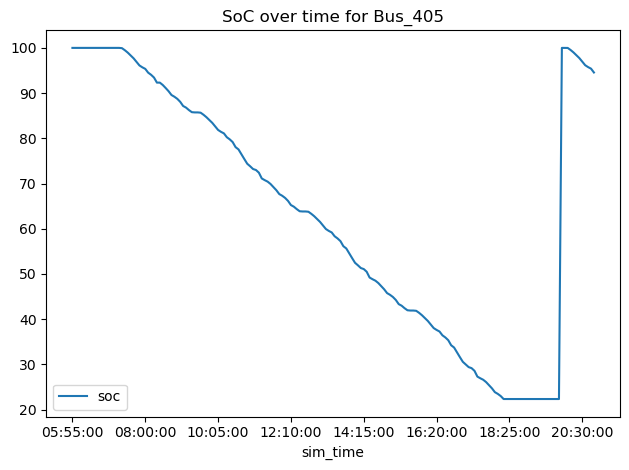

In [10]:
# Sample SoC over time for one bus
bus_col = "bus_id" if "bus_id" in df.columns else None
soc_col = "soc" if "soc" in df.columns else None
time_col = "sim_time" if "sim_time" in df.columns else None

if all([bus_col, soc_col, time_col]) and not df[bus_col].dropna().empty:
    bus_id = df[bus_col].dropna().iloc[1]
    df_bus = df[df[bus_col] == bus_id].sort_values(time_col)
    df_bus.plot(x=time_col, y=soc_col, title=f"SoC over time for {bus_id}")
    plt.tight_layout()
    plt.show()
else:
    print("Skipping SoC plot; missing one of bus_id/soc/sim_time columns or no bus entries.")

C:\Users\srijithbalakrishnan\AppData\Local\Temp\ipykernel_29660\1327285314.py:24: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  t_dt = pd.to_datetime(t_series, errors="coerce")


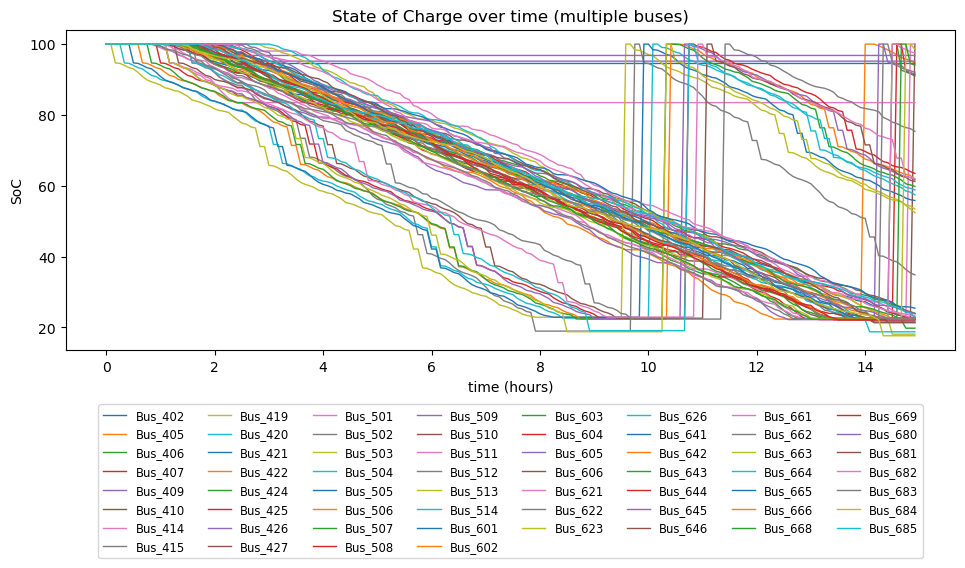

In [11]:
# Plot SoC over time for multiple buses (time in hours, legend at bottom)
possible_time_cols = ["sim_time", "time", "timestamp", "datetime"]
possible_soc_cols = ["soc", "state_of_charge", "battery", "battery_soc"]
possible_bus_cols = ["bus_id", "vehicle_id", "bus"]

# pick available columns
bus_col = next((c for c in possible_bus_cols if c in df.columns), None)
time_col = next((c for c in possible_time_cols if c in df.columns), None)
soc_col = next((c for c in possible_soc_cols if c in df.columns), None)

if all([bus_col, soc_col, time_col]) and not df[bus_col].dropna().empty:
    bus_ids = df[bus_col].dropna().unique().tolist()
    max_to_plot = 60  # cap for readability
    to_plot = bus_ids if len(bus_ids) <= max_to_plot else bus_ids[:max_to_plot]
    if len(bus_ids) > max_to_plot:
        print(f"Plotting first {max_to_plot} of {len(bus_ids)} buses for readability.")

    # prepare time to hours
    t_series = df[time_col]
    t_num = pd.to_numeric(t_series, errors="coerce")
    if t_num.notna().any():
        t_seconds = t_num
    else:
        t_dt = pd.to_datetime(t_series, errors="coerce")
        if t_dt.notna().any():
            t_seconds = (t_dt - t_dt.min()).dt.total_seconds()
        else:
            t_seconds = pd.Series(range(len(df)), index=df.index, dtype=float)
            print("Using row index as time because time column is non-numeric and non-datetime.")
    df = df.copy()
    df["_time_hours"] = t_seconds / 3600.0
    df["_soc_num"] = pd.to_numeric(df[soc_col], errors="coerce")

    plt.figure(figsize=(10, 6))
    any_plotted = False
    for b in to_plot:
        d = df[df[bus_col] == b]
        mask = d["_time_hours"].notna() & d["_soc_num"].notna()
        if not mask.any():
            continue
        any_plotted = True
        plt.plot(d.loc[mask, "_time_hours"], d.loc[mask, "_soc_num"], label=str(b), linewidth=1)

    if not any_plotted:
        print("No numeric time/SoC data to plot after cleaning.")
    else:
        plt.title("State of Charge over time (multiple buses)")
        plt.xlabel("time (hours)")
        plt.ylabel("SoC")
        plt.legend(loc="upper center", bbox_to_anchor=(0.5, -0.15), fontsize="small", ncol=8)
        plt.tight_layout()
        plt.show()
else:
    print("Skipping multi-bus SoC plot; missing bus/time/soc columns or no bus entries.")